In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [16]:
# Initialisation de Spark
spark = SparkSession.builder.appName("Titanic_Classification")  \
    .config("spark.master","spark://spark-master:7077")\
    .getOrCreate()

In [17]:
# Charger les données depuis HDFS (ou une autre source)
data_path = "hdfs://namenode:9000/user/data/titanic.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [18]:
# Filtrer et sélectionner les colonnes utiles
df = df.select(
    col("Survived").alias("label"),  # Étiquette : survie (0 ou 1)
    "Pclass",     # Classe du passager
    "Sex",        # Sexe
    "Age",        # Âge
    "SibSp",      # Nombre de frères et sœurs/époux à bord
    "Parch",      # Nombre de parents/enfants à bord
    "Fare",       # Tarif payé
    "Embarked"    # Port d'embarquement
)

In [19]:
# Remplacer les valeurs manquantes par la moyenne pour les colonnes numériques
numerical_cols = ["Age", "SibSp", "Parch", "Fare"]
for col_name in numerical_cols:
    mean_value = df.select(mean(col(col_name))).collect()[0][0]
    df = df.fillna({col_name: mean_value})

In [20]:
# Encodage des variables catégoriques avec gestion des valeurs nulles
sex_indexer = StringIndexer(inputCol="Sex", outputCol="SexIndex", handleInvalid="skip")
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex", handleInvalid="skip")
df = sex_indexer.fit(df).transform(df)
df = embarked_indexer.fit(df).transform(df)

In [21]:
# Assembleur pour créer un vecteur de features
assembler = VectorAssembler(
    inputCols=["Pclass", "SexIndex", "Age", "SibSp", "Parch", "Fare", "EmbarkedIndex"],
    outputCol="features"
)
df = assembler.transform(df)

In [22]:
# Diviser les données en ensembles d'entraînement et de test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [23]:

# Modèle de régression logistique pour la classification binaire
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [24]:
# Validation croisée
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [25]:
# Grille de paramètres
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1.0]).build()

In [26]:
# Évaluateur
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")


In [27]:
# CrossValidator
crossval = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)


In [28]:
# Entraînement avec validation croisée
cv_model = crossval.fit(train_data)

In [29]:
# Meilleur modèle
tuned_model = cv_model.bestModel

In [30]:
# Évaluation sur l'ensemble de test
predictions = tuned_model.transform(test_data)

In [31]:
# Extraction des probabilités et des labels
predictions_df = predictions.select("label", "probability").toPandas()

In [32]:
# Calcul de la courbe Precision-Recall
precision, recall, _ = precision_recall_curve(predictions_df["label"], predictions_df["probability"].apply(lambda x: x[1]))


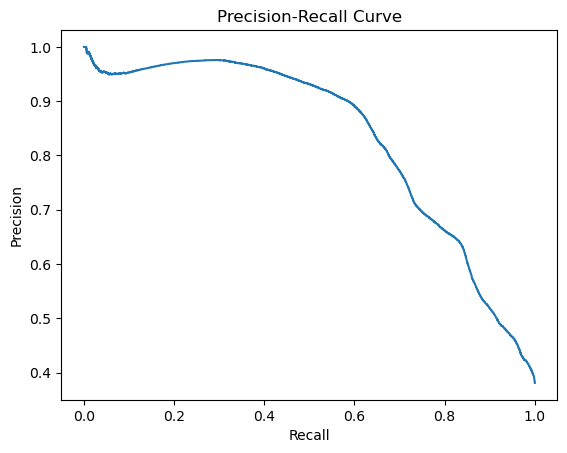

In [33]:
# Affichage de la courbe Precision-Recall
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
plt.title("Precision-Recall Curve")
plt.show()

In [34]:
# Afficher les métriques d'évaluation finales
auc = evaluator.evaluate(predictions)
print(f"AUC (Area Under Curve): {auc}")

AUC (Area Under Curve): 0.8598286269402463


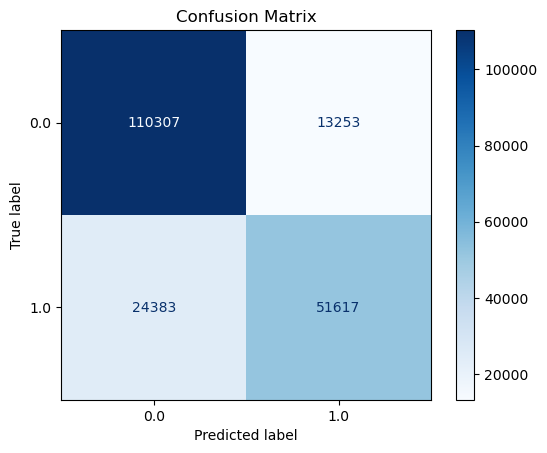

In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calcul et affichage de la matrice de confusion
conf_matrix = confusion_matrix(predictions_df["label"], predictions_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0.0, 1.0])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [37]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score
)
# Calcul des métriques
precision = precision_score(predictions_df["label"], predictions_df["prediction"])
recall = recall_score(predictions_df["label"], predictions_df["prediction"])
accuracy = accuracy_score(predictions_df["label"], predictions_df["prediction"])

# Affichage des métriques
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Precision: 0.80
Recall: 0.68
Accuracy: 0.81
